# Assignment 1: AML

## train

In [5]:
## Imports 

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import csv
#from textblob import TextBlob
import pandas
import sklearn
#import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
#from sklearn.learning_curve import learning_curve

In [6]:
## Loading files

train=pd.read_csv("train.csv")
val=pd.read_csv("validation.csv")
test=pd.read_csv("test.csv")

In [9]:
import re
import contractions
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string 

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [2]:
## Preprocessing steps

def preprocessing(sentence):

    punct = r"[!\"#\$%&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]"
    tokenize = RegexpTokenizer(r'\w+')
  
    sentence = re.sub(punct, "", sentence)
    sentence = contractions.fix(sentence)
    sentence = re.sub(r'https?', "", sentence) 
    sentence = re.sub(r'[0-9]', '', sentence)
    sentence = sentence.lower()
    sentence = tokenize.tokenize(sentence)

    return(sentence)

In [10]:
count_vectorize = CountVectorizer(analyzer=preprocessing) 
vectorized = count_vectorize.fit_transform(train.X_train)

In [12]:
message = train["X_train"][4]
message4 = count_vectorize.transform([message])

print(message4)
print(message4.shape)

  (0, 2078)	1
  (0, 2774)	1
  (0, 4360)	1
  (0, 4861)	1
  (0, 7067)	1
(1, 7117)


In [13]:
message = test["X_test"][4]
message4 = count_vectorize.transform([message])

print(message4)
print(message4.shape)

  (0, 102)	1
  (0, 560)	1
  (0, 1314)	1
  (0, 2346)	1
  (0, 2464)	1
  (0, 2883)	1
  (0, 2992)	1
  (0, 3150)	1
  (0, 4314)	1
  (0, 4926)	1
  (0, 5173)	1
  (0, 6241)	1
  (0, 6259)	1
  (0, 6312)	1
  (0, 6900)	1
  (0, 7048)	1
(1, 7117)


In [14]:
bag_of_words=count_vectorize.vocabulary_

In [16]:
len(bag_of_words)

7117

In [17]:
X_train= count_vectorize.transform(train.X_train)
X_val = count_vectorize.transform(val.X_val)
X_test= count_vectorize.transform(test.X_test)

In [19]:
X_train

<4013x7117 sparse matrix of type '<class 'numpy.int64'>'
	with 55095 stored elements in Compressed Sparse Row format>

In [20]:
tfidf_transformer = TfidfTransformer().fit(X_train)
X_train_tfidf = tfidf_transformer.transform(X_train)

In [21]:
X_val_tfidf=tfidf_transformer.transform(X_val)
X_test_tfidf=tfidf_transformer.transform(X_test)

In [22]:
X_val_tfidf

<446x7117 sparse matrix of type '<class 'numpy.float64'>'
	with 5964 stored elements in Compressed Sparse Row format>

## Fitting the model

### MultinomialNB

In [23]:
spam_detector_MNB = MultinomialNB().fit(X_train_tfidf, train.y_train)

In [27]:
y_pred_train = spam_detector_MNB.predict(X_train_tfidf)
accuracy_score(train.y_train, y_pred_train)

0.9611263393969599

In [28]:
y_pred_val = spam_detector_MNB.predict(X_val_tfidf)
accuracy_score(val.y_val, y_pred_val)

0.9573991031390134

In [79]:
# Since the accuracy of train set and validation set is close we can proceed further to predict test set 

y_pred_test = spam_detector_MNB.predict(X_test_tfidf)
test_score_MNB = accuracy_score(test.y_test, y_pred_test)
test_score_MNB

0.9417040358744395

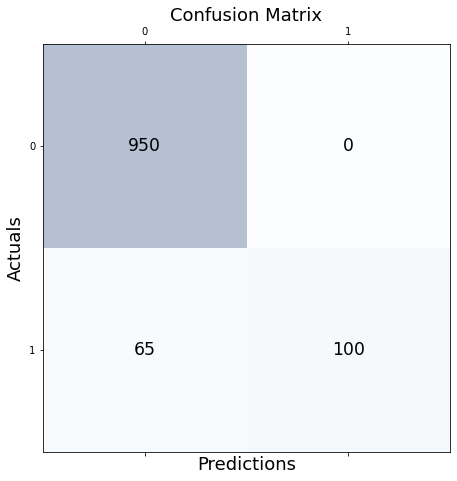

In [34]:
conf_matrix = confusion_matrix(y_true = test.y_test, y_pred=y_pred_test)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
print(classification_report(test.y_test, y_pred_test))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       950
        spam       1.00      0.61      0.75       165

    accuracy                           0.94      1115
   macro avg       0.97      0.80      0.86      1115
weighted avg       0.95      0.94      0.94      1115



In [37]:
pipeline_MNB = Pipeline([
    ('bow', CountVectorizer(analyzer= preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         train.X_train,  # training data
                         train.y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.93781095 0.93781095 0.94029851 0.96009975 0.93017456 0.95012469
 0.94763092 0.95760599 0.94763092 0.96758105]


In [44]:
avg_score = sum(scores)/len(scores)

print(avg_score)

0.9476768278309203


In [45]:
print(scores.std())

0.011002415675866666


### SVM

In [46]:
pipeline_SVM = Pipeline([
    ('bow', CountVectorizer(analyzer= preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC(kernel='rbf')),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [55]:
scores_SVM = cross_val_score(pipeline_SVM,  # steps to convert raw messages into models
                         train.X_train,  # training data
                         train.y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores_SVM)

[0.97014925 0.97512438 0.96766169 0.9925187  0.96758105 0.98753117
 0.98004988 0.97755611 0.98753117 0.99501247]


In [58]:
scores_SVM.mean() , scores_SVM.std()

(0.9800715872011514, 0.009637044293821862)

In [52]:
spam_detector_SVC = SVC().fit(X_train_tfidf, train.y_train)

In [53]:
y_pred_val = spam_detector_SVC.predict(X_val_tfidf)
accuracy_score(val.y_val, y_pred_val)

0.9775784753363229

In [78]:
# Since the accuracy of train set and validation set is close we can proceed further to predict test set 

y_pred_test = spam_detector_SVC.predict(X_test_tfidf)
test_score_SVM = accuracy_score(test.y_test, y_pred_test)
test_score_SVM

0.9739910313901345

In [59]:
print(classification_report(test.y_test, y_pred_test))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       950
        spam       0.99      0.83      0.90       165

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



### KNN

In [60]:
### KNN
from sklearn.neighbors import KNeighborsClassifier

In [69]:
## Let's try on different k_values 
for i in range(2,6):
    k = i
    spam_detector_KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train_tfidf, train.y_train)
    y_pred_train = spam_detector_KNN.predict(X_train_tfidf)
    print(accuracy_score(train.y_train, y_pred_train))
    

0.9521554946424121
0.9521554946424121
0.9269872913032644
0.9269872913032644


In [66]:
# So, let's make our model at k=2

In [67]:

pipeline_KNN = Pipeline([
    ('bow', CountVectorizer(analyzer= preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', KNeighborsClassifier(n_neighbors = k)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [70]:
k = 2
 
scores_KNN = cross_val_score(pipeline_KNN,  # steps to convert raw messages into models
                         train.X_train,  # training data
                         train.y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores_KNN)

[0.89800995 0.95771144 0.91293532 0.92518703 0.94014963 0.96009975
 0.91022444 0.9201995  0.89276808 0.91770574]


In [76]:
scores_KNN.mean() , scores_KNN.std()

(0.923499088100644, 0.021717582596224024)

In [71]:
spam_detector_KNN = KNeighborsClassifier(n_neighbors = 2).fit(X_train_tfidf, train.y_train)

In [73]:
y_pred_val = spam_detector_KNN.predict(X_val_tfidf)
accuracy_score(val.y_val, y_pred_val)

0.9260089686098655

In [77]:
# Since the accuracy of train set and validation set is close we can proceed further to predict test set 

y_pred_test = spam_detector_KNN.predict(X_test_tfidf)
test_score_KNN = accuracy_score(test.y_test, y_pred_test)
test_score_KNN

0.9165919282511211

In [84]:
print(f"test score for multinomialNB is  {test_score_MNB} \n" )
print(f"test score for SVM is  {test_score_SVM} \n")
print(f"test score for KNN is  {test_score_KNN} \n")

test score for multinomialNB is  0.9417040358744395 

test score for SVM is  0.9739910313901345 

test score for KNN is  0.9165919282511211 



### Hence SVM is the best model